<a href="https://colab.research.google.com/github/so-dipe/ubiquitous-fortnight/blob/main/Price_Pred_%2B_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
! pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [1]:
import pandas as pd

In [279]:
file_path = "/content/products_export_1-2.csv"

df = pd.read_csv(file_path)
print(df.shape)
df.head()

(13285, 53)


,Handle,Title,Body (HTML),Vendor,Product Category,Type,Tags,Published,Option1 Name,Option1 Value,...,Variant Weight Unit,Variant Tax Code,Cost per item,Included / Canada,Price / Canada,Compare At Price / Canada,Included / United States,Price / United States,Compare At Price / United States,Status
0,12395avocado-pull-toy,Avocado Pull Toy,<p>Holy Guacamole! Pull the avocado down and w...,Jellycat,NaN,Toys,"23dec3, _badge_Jellycat, vendor_ET141",False,Title,Default Title,...,kg,NaN,3.25,True,NaN,NaN,True,NaN,NaN,active
1,12394plaid-shirt-3t,Plaid Shirt | 3T,"<p>Long-sleeved white, red and light blue plai...",Jumping Beans,NaN,Tops,"3T, _badge_Jumping Beans, vendor_ET141",False,Title,Default Title,...,kg,NaN,3.25,True,NaN,NaN,True,NaN,NaN,active
2,12393heattech-tee-3t,HeatTech Tee | 3T,<p>White long-sleeved HeatTech t-shirt</p><p>S...,Uniqlo,NaN,Tops,"_badge_Uniqlo, vendor_ET141",False,Title,Default Title,...,kg,NaN,2.75,True,NaN,NaN,True,NaN,NaN,active
3,12392batman-bib,Batman Bib,<p>Soft water-resistant fabric Batman bib</p><...,Various,NaN,Accessories,"23dec2, _badge_Various, vendor_ET141",True,Title,Default Title,...,kg,NaN,1.40,True,NaN,NaN,True,NaN,NaN,active
4,12391plaid-bodysuit-6-12mos,Plaid Bodysuit | 6-12mos,<p>Long-sleeved plaid dress shirt bodysuit</p>...,Gap,NaN,Tops,"6-12mos, _badge_Gap, vendor_ET141",False,Title,Default Title,...,kg,NaN,3.90,True,NaN,NaN,True,NaN,NaN,active


In [280]:
active_msk = df["Status"] == "active"

#filter active items
df = df[active_msk]
print(df["Status"].unique())
print(df.shape)

['active']
(8247, 53)


In [281]:
df["Body (HTML)"][1]

'<p>Long-sleeved white, red and light blue plaid dress shirt</p><p>Size: 3T</p><p>Condition: Very good *light pilling</p>'

In [282]:
from bs4 import BeautifulSoup

def extract_info(html_content):
    if pd.isnull(html_content):
        return None, None, None

    soup = BeautifulSoup(html_content, 'html.parser')
    paragraphs = soup.find_all('p')
    size = None
    condition = None
    additional_info = None

    # Loop through paragraphs to find size, condition, and additional details
    for p in paragraphs:
        if 'Size:' in p.text:
            size = p.text.replace('Size:', '').strip()  # Extract size
        elif 'Condition:' in p.text:
            condition_text = p.text.replace('Condition:', '').strip()
            # Split based on asterisk (*) to separate condition and additional information
            parts = condition_text.split('*')
            condition = parts[0].strip()  # Extract condition
            if len(parts) > 1:
                additional_info = parts[1].strip()  # Extract additional information
            break  # Break the loop once condition is found

    return size, condition, additional_info

In [283]:
#check number of null values in Body (HTML)
print(df['Body (HTML)'].isna().sum())

#fill null values with zero
df['Body (HTML)'].fillna("0", inplace=True)

5


In [284]:
# Apply function to extract condition
df['Size'], df['Condition'], df['Additional Info'] = zip(*df['Body (HTML)'].apply(extract_info))

In [285]:
df['Condition'].unique()[:10]

array(['Excellent', 'Very good', 'New without tags', 'Good',
       'New with tags', 'Practically new', '',
       'Play condition (some stains or marks, no rips)', 'New in box',
       'New in package'], dtype=object)

In [286]:
def categorize_condition(condition):
    condition = condition.lower()  # Convert to lowercase for uniform comparison

    if 'excellent' in condition:
        return 'excellent'
    elif 'very good' in condition:
        return 'very good'
    elif 'like new' in condition or 'practically new' in condition:
        return 'like new'
    elif 'new with tags' in condition:
        return 'new with tags'
    elif 'new without tags' in condition:
        return 'new without tags'
    elif 'good' in condition:
        return 'good'
    elif 'play' in condition:
        return 'play'
    else:
        return 'unknown'  # Assign unknown for unknown/vague conditions or empty strings

In [287]:
df['Condition'].fillna(' ', inplace=True)

df['Cleaned Condition'] = df['Condition'].apply(categorize_condition)

In [288]:
def extract_size_from_title(title):
    # Split the title using the '|' separator
    parts = title.split('|')

    if len(parts) > 1:
        size_value = parts[1].strip()  # Extract the size value after the '|'
        return size_value
    else:
        return "unknown"

In [289]:
df['Size'] = df['Title'].apply(extract_size_from_title)

In [290]:
# df['Size'].unique()

In [291]:
df['Title'][df['Title'].str.contains('\+')]

11                              Top + Shorts Set | 12mos
20                              Wooden Coin Bank + Coins
24                                 Slide + Seek Ball Run
42                                 Jumper + Tops | 24mos
44                         Sweatshirt + Leggings | 24mos
                              ...                       
13036                      Blouse + Legging Set | 3-6mos
13038                      Sweatshirt + Joggers | 3-6mos
13052                         Dress + Bloomers | 6-12mos
13218    Rocket + Stars Lightweight Sweatshirt | 6-12mos
13237                      Red + White Shorts | 12-18mos
Name: Title, Length: 336, dtype: object

In [292]:
df['Type'].unique()

array(['Toys', 'Tops', 'Accessories', 'Dresses + Skirts', 'Sweaters',
       'Shorts', 'Sets', 'Rompers', 'Pants', 'PJs + Sleep Sacks', 'Swim',
       'Footwear', 'Costumes', 'Outerwear', 'Gear', 'Maternity + Nursing',
       'Short', 'Blazers + Suits', nan, 'Gift Cards'], dtype=object)

In [293]:
df["joggers"] = df['Title'].str.contains('Joggers') * 1
df["jeans"] = df['Title'].str.contains('Jeans') * 1
df["leggings"] = df['Title'].str.contains('Leggings') * 1

In [294]:
feature_set = {"Type", "Vendor", "Cleaned Condition", "Variant Price"}
# target =

In [295]:
ds = df[list(feature_set)]
ds.head()

,Cleaned Condition,Type,Vendor,Variant Price
0,excellent,Toys,Jellycat,13.0
1,very good,Tops,Jumping Beans,13.0
2,excellent,Tops,Uniqlo,11.0
3,excellent,Accessories,Various,7.0
4,excellent,Tops,Gap,13.0


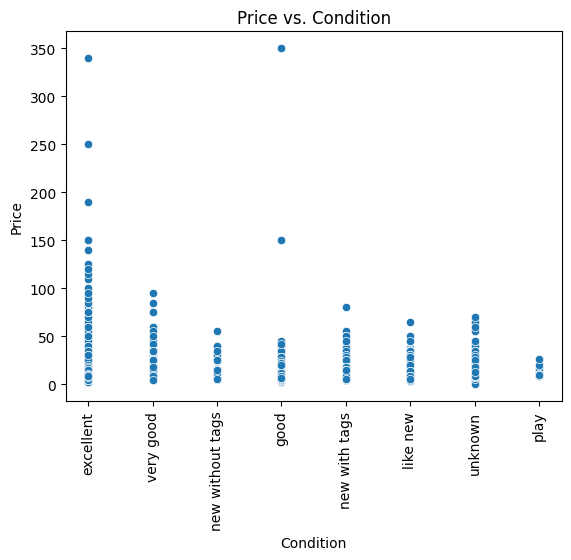

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Variant Price vs. Condition
sns.scatterplot(x='Cleaned Condition', y='Variant Price', data=ds)
plt.xlabel('Condition')
plt.ylabel('Price')
plt.title('Price vs. Condition')
plt.xticks(rotation=90)
plt.show()

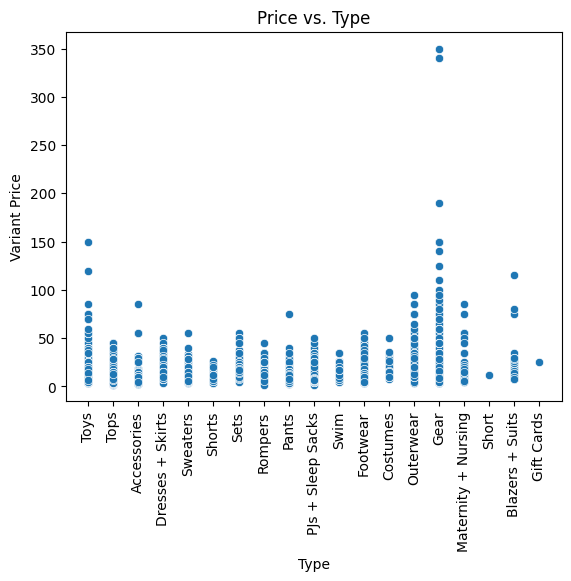

In [297]:
# Scatter plot: Price vs. Type
sns.scatterplot(x='Type', y='Variant Price', data=ds)
plt.xlabel('Type')
plt.ylabel('Variant Price')
plt.title('Price vs. Type')
plt.xticks(rotation=90)
plt.show()


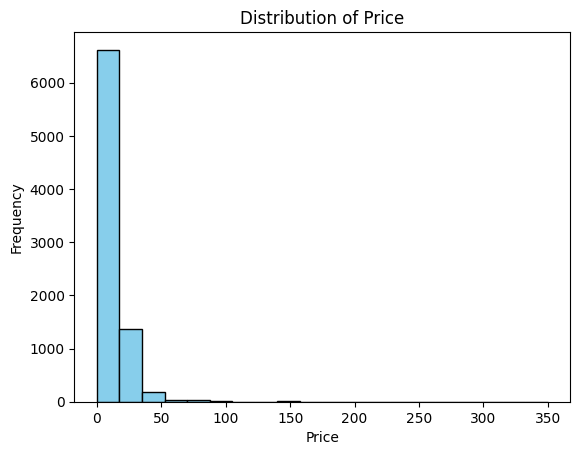

In [298]:
# Plotting the histogram for 'Price'
plt.hist(ds['Variant Price'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

In [299]:
outlier_msk = ds['Variant Price'] < 300
ds = ds[outlier_msk]

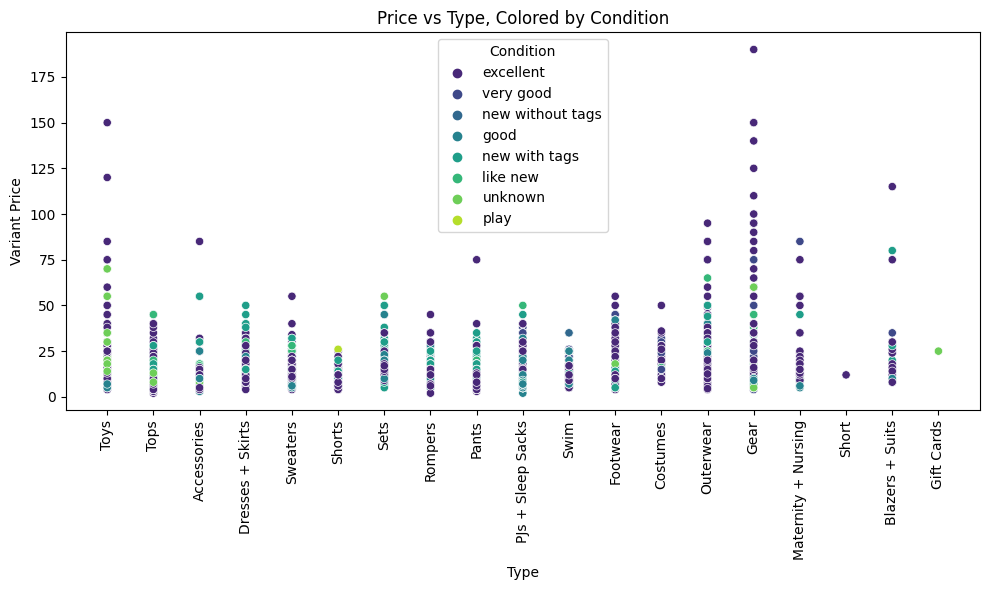

In [300]:
plt.figure(figsize=(10, 6))

# Create a scatter plot for Price vs Type, colored by Condition
sns.scatterplot(x='Type', y='Variant Price', hue='Cleaned Condition', data=ds, palette='viridis')

plt.xlabel('Type')
plt.ylabel('Variant Price')
plt.title('Price vs Type, Colored by Condition')

plt.xticks(rotation=90)
plt.legend(title='Condition')
plt.tight_layout()

plt.show()

In [301]:
ds['Type'].fillna('unknown', inplace=True)

In [302]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Separate features (X) and the target variable (y)
X = ds.drop(columns=['Variant Price'])  # Features (all columns except 'Variant Price')
y = ds['Variant Price']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [303]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Define the transformer for ordinal encoding
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Create a pipeline for encoding and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_encoder', ordinal_encoder, categorical_cols),
    ],
    remainder='passthrough'
)

# Create a linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [304]:
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Baseline Model): {mse}")
print(f"R^2 Score (Baseline Model): {r2}")

Mean Squared Error (Baseline Model): 106.6695977879619
R^2 Score (Baseline Model): 0.029797449854101377


In [305]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a pipeline for encoding and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', one_hot_encoder, categorical_cols),
    ],
    remainder='passthrough'
)

# Create a linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 6.083002057170925e+21
R^2 Score: -5.532733066212062e+19


In [306]:
from category_encoders import TargetEncoder

target_encode_col = ['Vendor']  # Column to target encode
ordinal_encode_cols = X.select_dtypes(include=['object']).columns.difference(target_encode_col).tolist()

# Define transformers for target and ordinal encoding
target_encoder = TargetEncoder()
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Create a pipeline for encoding and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', target_encoder, target_encode_col),
        ('ordinal_encoder', ordinal_encoder, ordinal_encode_cols),
    ],
    remainder='passthrough'
)

# Create a linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 85.66750567398981
R^2 Score: 0.22081985689344197


In [307]:
target_encode_col = ['Vendor']  # Column to target encode
non_target_encode_cols = X.select_dtypes(include=['object']).columns.difference(target_encode_col).tolist()

target_encoder = TargetEncoder()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a pipeline for encoding and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', target_encoder, target_encode_col),
        ('one_hot_encoder', one_hot_encoder, non_target_encode_cols),
    ],
    remainder='passthrough'
)

# Create a linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 75.21097066780905
R^2 Score: 0.31592621464734105


In [308]:
pipeline = Pipeline([
    ('target_encoder', TargetEncoder()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score : {r2}")

Mean Squared Error: 73.41944074060865
R^2 Score : 0.3322208941068776


In [309]:
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('target_encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (with Normalization): {mse}")
print(f"R^2 Score (with Normalization): {r2}")

Mean Squared Error (with Normalization): 73.41944074060865
R^2 Score (with Normalization): 0.3322208941068775


In [310]:
import joblib

model_filename = 'model.pkl'

# Save the model
joblib.dump(pipeline, model_filename)

['model.pkl']

In [311]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pipelines = {
    'DecisionTree': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Fit and evaluate each model
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score : {r2}")
    print("----------------------")

Model: DecisionTree
Mean Squared Error: 80.08081655332067
R^2 Score : 0.2716330233827341
----------------------
Model: RandomForest
Mean Squared Error: 70.09746860533531
R^2 Score : 0.362435556053597
----------------------
Model: GradientBoosting
Mean Squared Error: 71.77964065636053
R^2 Score : 0.34713553010868814
----------------------


In [312]:
from sklearn.model_selection import GridSearchCV

# Define the pipelines with default hyperparameters
pipelines = {
    'DecisionTree': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('target_encoder', TargetEncoder()),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Hyperparameters to tune for each model
param_grids = {
    'DecisionTree': {'regressor__max_depth': [None, 5, 10, 15]},
    'RandomForest': {'regressor__max_depth': [None, 5, 10, 15],
                     'regressor__min_samples_split': [2, 5, 10]},
    'GradientBoosting': {'regressor__max_depth': [3, 5, 7],
                         'regressor__learning_rate': [0.1, 0.05, 0.01]}
}

# Perform GridSearchCV for each model
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    # Best hyperparameters
    print(f"Best hyperparameters for {name}:")
    print(grid_search.best_params_)

    # Evaluate model with best hyperparameters on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print("----------------------")


Best hyperparameters for DecisionTree:
{'regressor__max_depth': 5}
Mean Squared Error: 80.36286025843553
R^2 Score: 0.2690677233569575
----------------------
Best hyperparameters for RandomForest:
{'regressor__max_depth': 15, 'regressor__min_samples_split': 10}
Mean Squared Error: 69.82945796658358
R^2 Score: 0.3648732197419897
----------------------
Best hyperparameters for GradientBoosting:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 3}
Mean Squared Error: 71.77964065636053
R^2 Score: 0.34713553010868814
----------------------


In [313]:
df[['SizeNumeric', 'SizeLetters']] = df['Size'].str.extract(r'(\d+-?\d*)(\D+)')

In [314]:
df['SizeNumeric'].unique()

array([nan, '3', '6-12', '12-18', '9-12', '6-9', '12', '24', '9', '4-5',
       '7', '6-8', '6', '4', '5', '5-6', '18-24', '2-3', '2', '12-24',
       '6-18', '18-36', '2-4', '3-4', '1-2', '18', '0-6', '6-7', '3-6',
       '7-8', '4-6', '0-4', '0-3', '48', '40', '4-7', '10', '14', '10-12',
       '13-14', '14-16', '12-13', '9-10', '8-9', '12-14', '14-15',
       '15-16', '1', '8', '6-6', '13', '3-9', '36', '0-2', '11', '8-10',
       '9-11', '4-8', '1-3', '0-24', '0-12', '34', '25', '0-1', '10-11',
       '20-33', '3-12', '9-18', '0-9', '9-24', '16', '24-36', '3-5',
       '0-18', '5-7', '6-36', '0-5', '16-26', '7-18', '23', '1-4', '2-6',
       '6-24', '2-5', '11-12', '28', '70', '3-18', '17-24'], dtype=object)

In [315]:
def normalize_size(size_range):
    if '-' in size_range:  # For range values
        lower, upper = map(int, size_range.split('-'))
        return (lower + upper) / 2
    else:  # For single values
        return int(size_range)

df['SizeNumeric'].fillna('0', inplace=True)

df['NormalizedSize'] = df['SizeNumeric'].apply(normalize_size)

In [316]:
df['SizeLetters'].unique()

array([nan, 'T', 'mos', ' Youth', 'Y', ' Shoes (Toddler)', '.',
       ' Shoes (Infant)', 'cm', 'os', 'DD', ' Shoes (Youth)',
       ' Shoes (Toddler', ' Shoes (Infant/Toddler)', 'yr',
       ' Shoes (Child/Toddler)', ' Shoes', ' mos', ' Infant Shoes',
       'mos - ', ' Youth Shoes', 'D', " Women's)", 'yrs', 'mnos', 'lb',
       ' Shoes (Big Kid)', 'X', ' Infant', ' Toddler', ' Toddler Shoes',
       'T-', ' Skates', 'T *small fit', ' Waist', '/', " Women's",
       'X Youth', 'S', 'X-', ' (Approx ', ' months'], dtype=object)

In [317]:
import re

def clean_size_letters(size_str):
    size_str = re.sub(r'\W+', '', str(size_str))  # Remove non-alphanumeric characters
    size_str = size_str.strip()  # Remove leading/trailing spaces
    # Map similar units/categories together
    if size_str in ['T', 'Toddler', 'T-', 'Tsmallfit']:  # Example mappings
        return 'Toddler'
    elif size_str in ['mos', 'months', 'mnos']:
        return 'Months'
    elif size_str in ['Youth', 'XYouth', 'X']:
        return 'Youth'
    elif 'Shoes' in size_str:
        if size_str in ["InfantShoes", "ShoesInfant"]:
            return "Shoes Infant"
        elif size_str in ["YouthShoes", "ShoesYouth"]:
            return "Shoes Youth"
        elif size_str in ["ToddlerShoes", "ShoesToddler"]:
            return "Shoes Toddler"
        else:
            return "Shoes"
    elif size_str in ['yrs', 'yr', 'Y']:
        return 'Year'
    elif size_str in ['nan', '']:
        return 'unknown'
    else:
        return size_str

df['SizeLetters'].fillna('')
# Apply the cleaning function to the 'SizeLetters' column
df['CleanedSizeLetters'] = df['SizeLetters'].apply(clean_size_letters)

In [318]:
df['CleanedSizeLetters'].value_counts()

Months           4325
Toddler          2066
unknown           687
Youth             417
Year              314
Shoes             201
Shoes Toddler     167
Shoes Infant       41
Shoes Youth        10
lb                  4
DD                  3
Infant              3
Womens              2
os                  1
cm                  1
D                   1
Skates              1
Waist               1
S                   1
Approx              1
Name: CleanedSizeLetters, dtype: int64

In [319]:
feature_set = {"Type", "Vendor", "Cleaned Condition", "Variant Price", "CleanedSizeLetters", "NormalizedSize", "joggers", "jeans", "leggings"}
ds = df[list(feature_set)]
ds= ds[outlier_msk]
ds.head()

,NormalizedSize,CleanedSizeLetters,joggers,Cleaned Condition,jeans,leggings,Variant Price,Type,Vendor
0,0.0,unknown,0,excellent,0,0,13.0,Toys,Jellycat
1,3.0,Toddler,0,very good,0,0,13.0,Tops,Jumping Beans
2,3.0,Toddler,0,excellent,0,0,11.0,Tops,Uniqlo
3,0.0,unknown,0,excellent,0,0,7.0,Accessories,Various
4,9.0,Months,0,excellent,0,0,13.0,Tops,Gap


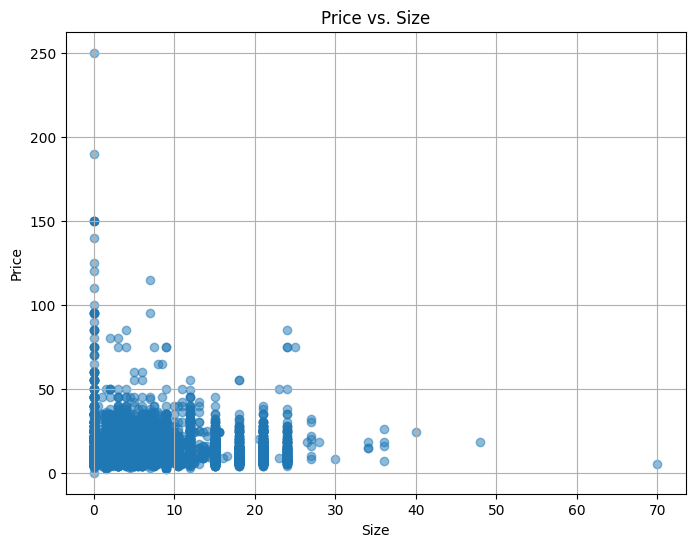

In [320]:
import matplotlib.pyplot as plt

# Assuming 'Size' column contains cleaned numeric values (floats or integers)
plt.figure(figsize=(8, 6))
plt.scatter(ds['NormalizedSize'], ds['Variant Price'], alpha=0.5)
plt.title('Price vs. Size')
plt.xlabel('Size')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [321]:
X = ds.drop('Variant Price', axis=1)  # Features
y = ds['Variant Price']  # Target variable

# Splitting the data into train and test sets (change test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
categorical_cols = ['Vendor', 'Type', 'Cleaned Condition']  # Columns to target encode
one_hot_cols = ['CleanedSizeLetters']  # Column to one-hot encode

# Define the transformers for different column types
target_encoder = TargetEncoder()
one_hot_transformer = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')

# Create a preprocessor for target encoding and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', target_encoder, categorical_cols),
        ('one_hot', one_hot_transformer, one_hot_cols),
    ],
    remainder='passthrough'  # Pass through any columns not specified
)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 72.71933700183553
R^2 Score: 0.33858861693334363


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [323]:
model_filename = 'optional_model.pkl'

# Save the model
joblib.dump(pipeline, model_filename)

['optional_model.pkl']

In [362]:
import re

def extract(text):
    match = re.match(r'(\d+-?\d*)(\D+)', text)
    if match:
        return match.groups()
    return "0", "unknown"

def categorize_condition(condition):
    condition = condition.lower()  # Convert to lowercase for uniform comparison

    if 'excellent' in condition:
        return 'excellent'
    elif 'very good' in condition:
        return 'very good'
    elif 'like new' in condition or 'practically new' in condition:
        return 'like new'
    elif 'new with tags' in condition:
        return 'new with tags'
    elif 'new without tags' in condition:
        return 'new without tags'
    elif 'good' in condition:
        return 'good'
    elif 'play' in condition:
        return 'play'
    else:
        return 'unknown'  # Assign unknown for unknown/vague conditions or empty strings

def normalize_size(size_range):
    if '-' in size_range:  # For range values
        lower, upper = map(int, size_range.split('-'))
        return (lower + upper) / 2
    else:  # For single values
        return int(size_range)

def clean_size_letters(size_str):
    size_str = re.sub(r'\W+', '', str(size_str))  # Remove non-alphanumeric characters
    size_str = size_str.strip()  # Remove leading/trailing spaces
    # Map similar units/categories together
    if size_str in ['T', 'Toddler', 'T-', 'Tsmallfit']:  # Example mappings
        return 'Toddler'
    elif size_str in ['mos', 'months', 'mnos']:
        return 'Months'
    elif size_str in ['Youth', 'XYouth', 'X']:
        return 'Youth'
    elif 'Shoes' in size_str:
        if size_str in ["InfantShoes", "ShoesInfant"]:
            return "Shoes Infant"
        elif size_str in ["YouthShoes", "ShoesYouth"]:
            return "Shoes Youth"
        elif size_str in ["ToddlerShoes", "ShoesToddler"]:
            return "Shoes Toddler"
        else:
            return "Shoes"
    elif size_str in ['yrs', 'yr', 'Y']:
        return 'Year'
    elif size_str in ['nan', '']:
        return 'unknown'
    else:
        return size_str


In [363]:
def preprocess_input(vendor, type, condition, size=None, title=None):
    input_dict = {
        "Vendor": vendor,
        "Type": type,
        "Cleaned Condition": categorize_condition(condition),
        "NormalizedSize": 0,
        "CleanedSizeLetters":"unknown",
        "joggers":0,
        "jeans":0,
        "leggings":0
    }

    if size:
        try:
            number, letter = extract(size)
            input_dict["NormalizedSize"] = normalize_size(number)
            input_dict["CleanedSizeLetters"] = clean_size_letters(letter)
        except Exception as e:
            print(f"Error processing size: {e}")

    if title:
        try:
            if "joggers" in title.lower():
                input_dict["joggers"]= 1
            elif "jeans" in title.lower():
                input_dict["jeans"]= 1
            elif "leggings" in title.lower():
                input_dict["leggings"] = 1
        except Exception as e:
            print(f"Error processing title: {e}")

    return input_dict

In [364]:
def make_prediction(input_dict):
    input_df = pd.DataFrame([input_dict])
    model = joblib.load("optional_model.pkl")
    prediction = model.predict(input_df)
    return prediction[0]
